In [ ]:
#This script trains the machine learning models and produces the confusion matrix.

In [1]:

import numpy as np
from sklearn.model_selection import LeaveOneGroupOut,GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

nJobs = 12  # Number of cores to use

# Load feature matrices, labels, and groups (denoting which labeled time
# segment each row of the feature matrix comes from)
featuresAll = np.loadtxt('JohnAll.csv',delimiter=',')
featuresAcc = np.loadtxt('JohnAcc.csv',delimiter=',')
featuresEda = np.loadtxt('JohnEda.csv',delimiter=',')
labels = np.loadtxt('JohnLabels.csv',delimiter=',')
groups = np.loadtxt('JohnGroups.csv',delimiter=',')

# Leave-one-group-out cross-validation
cv = LeaveOneGroupOut() 

# Svm
# Parameter tuning by grid search
regParamC = 10. ** np.arange(-5, 4)
regParamG = 10. ** np.arange(-9, 1)
parameters = {'gamma': regParamG, 'C': regParamC}
              
svmgsAll = GridSearchCV(svm.SVC(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)              
svmgsAll.fit(featuresAll,labels,groups)


svmbestgamma_All = svmgsAll.best_params_['gamma']
svmbestC_All = svmgsAll.best_params_['C']

svmgsAcc = GridSearchCV(svm.SVC(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
svmgsAcc.fit(featuresAcc,labels,groups)
svmbestgamma_Acc = svmgsAcc.best_params_['gamma']
svmbestC_Acc = svmgsAcc.best_params_['C']

svmgsEda = GridSearchCV(svm.SVC(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
svmgsEda.fit(featuresEda,labels,groups)
svmbestgamma_Eda = svmgsEda.best_params_['gamma']
svmbestC_Eda = svmgsEda.best_params_['C']

svmpredAll = np.zeros(np.shape(labels))
svmpredAcc = np.zeros(np.shape(labels))
svmpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    svmAll = svm.SVC(gamma=svmbestgamma_All, C=svmbestC_All,probability=True)
    svmAll.fit(featuresAll[train,:],labels[train])
    svmpredAll[test] = svmAll.predict_proba(featuresAll[test,:])[:,1]

    svmAcc = svm.SVC(gamma=svmbestgamma_Acc, C=svmbestC_Acc,probability=True)
    svmAcc.fit(featuresAcc[train,:],labels[train])
    svmpredAcc[test] = svmAcc.predict_proba(featuresAcc[test,:])[:,1]

    svmEda = svm.SVC(gamma=svmbestgamma_Eda, C=svmbestC_Eda,probability=True)
    svmEda.fit(featuresEda[train,:],labels[train])
    svmpredEda[test] = svmEda.predict_proba(featuresEda[test,:])[:,1]

# Save the scores for further analysis
#np.save('svmpredAllScores_walk',svmpredAll)
#np.save('svmpredAccScores_walk',svmpredAcc)
#np.save('svmpredEdaScores_walk',svmpredEda)


# Logistic
# Parameter tuning by grid search
regParam = 10.0**-np.arange(-5,5)
parameters = {'C': regParam}

gsAll = GridSearchCV(LogisticRegression(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsAll.fit(featuresAll,labels,groups)
bestC_All = gsAll.best_params_['C']

gsAcc = GridSearchCV(LogisticRegression(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsAcc.fit(featuresAcc,labels,groups)
bestC_Acc = gsAcc.best_params_['C']

gsEda = GridSearchCV(LogisticRegression(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsEda.fit(featuresEda,labels,groups)
bestC_Eda = gsEda.best_params_['C']

LogisticpredAll = np.zeros(np.shape(labels))
LogisticpredAcc = np.zeros(np.shape(labels))
LogisticpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    lrAll = LogisticRegression(C=bestC_All)
    lrAll.fit(featuresAll[train,:],labels[train])
    LogisticpredAll[test] = lrAll.predict_proba(featuresAll[test,:])[:,1]

    lrAcc = LogisticRegression(C=bestC_Acc)
    lrAcc.fit(featuresAcc[train,:],labels[train])
    LogisticpredAcc[test] = lrAcc.predict_proba(featuresAcc[test,:])[:,1]

    lrEda = LogisticRegression(C=bestC_Eda)
    lrEda.fit(featuresEda[train,:],labels[train])
    LogisticpredEda[test] = lrEda.predict_proba(featuresEda[test,:])[:,1]

# Save the scores for further analysis
#np.save('LogisticpredAllScores_walk',LogisticpredAll)
#np.save('LogisticpredAccScores_walk',LogisticpredAcc)
#np.save('LogisticpredEdaScores_walk',LogisticpredEda)




# kNN classify
# Parameter tuning by grid search
parameters = {'n_neighbors': np.arange(1, 81)}

kNNgsAll = GridSearchCV(KNeighborsClassifier(algorithm='auto', metric='euclidean'),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
kNNgsAll.fit(featuresAll,labels,groups)
bestneighbors_All = kNNgsAll.best_params_['n_neighbors']

kNNgsAcc = GridSearchCV(KNeighborsClassifier(algorithm='auto', metric='euclidean'),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
kNNgsAcc.fit(featuresAcc,labels,groups)
bestneighbors_Acc = kNNgsAcc.best_params_['n_neighbors']

kNNgsEda = GridSearchCV(KNeighborsClassifier(algorithm='auto', metric='euclidean'),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
kNNgsEda.fit(featuresEda,labels,groups)
bestneighbors_Eda = kNNgsEda.best_params_['n_neighbors']              

knnCpredAll = np.zeros(np.shape(labels))
knnCpredAcc = np.zeros(np.shape(labels))
knnCpredEda = np.zeros(np.shape(labels))              
for train, test in cv.split(featuresAll,labels,groups):
    knnCAll = KNeighborsClassifier(n_neighbors=bestneighbors_All, algorithm='auto', metric='euclidean')
    knnCAll.fit(featuresAll[train,:],labels[train])
    knnCpredAll[test] = knnCAll.predict_proba(featuresAll[test,:])[:,1]

    knnCAcc = KNeighborsClassifier(n_neighbors=bestneighbors_Acc, algorithm='auto', metric='euclidean')
    knnCAcc.fit(featuresAcc[train,:],labels[train])
    knnCpredAcc[test] = knnCAcc.predict_proba(featuresAcc[test,:])[:,1]

    knnCEda = KNeighborsClassifier(n_neighbors=bestneighbors_Eda, algorithm='auto', metric='euclidean')
    knnCEda.fit(featuresEda[train,:],labels[train])
    knnCpredEda[test] = knnCEda.predict_proba(featuresEda[test,:])[:,1]

# Save the scores for further analysis
#np.save('knnCpredAllScores_walk',knnCpredAll)
#np.save('knnCpredAccScores_walk',knnCpredAcc)
#np.save('knnCpredEdaScores_walk',knnCpredEda)



# Random Forest
# Parameter tuning by grid search
RFparameters = {'n_estimators': 10*np.arange(1,21)}

RFgsAll = GridSearchCV(RandomForestClassifier(),
                     RFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
RFgsAll.fit(featuresAll,labels,groups)
RFbestNumTreesAll = RFgsAll.best_params_['n_estimators']

RFgsAcc = GridSearchCV(RandomForestClassifier(),
                     RFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
RFgsAcc.fit(featuresAcc,labels,groups)
RFbestNumTreesAcc = RFgsAcc.best_params_['n_estimators']

RFgsEda = GridSearchCV(RandomForestClassifier(),
                     RFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
RFgsEda.fit(featuresEda,labels,groups)
RFbestNumTreesEda = RFgsEda.best_params_['n_estimators']

RFpredAll = np.zeros(np.shape(labels))
RFpredAcc = np.zeros(np.shape(labels))
RFpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    RFAll = RandomForestClassifier(n_estimators=RFbestNumTreesAll)
    RFAll.fit(featuresAll[train,:],labels[train])
    RFpredAll[test] = RFAll.predict_proba(featuresAll[test,:])[:,1]

    RFAcc = RandomForestClassifier(n_estimators=RFbestNumTreesAcc)
    RFAcc.fit(featuresAcc[train,:],labels[train])
    RFpredAcc[test] = RFAcc.predict_proba(featuresAcc[test,:])[:,1]

    RFEda = RandomForestClassifier(n_estimators=RFbestNumTreesEda)
    RFEda.fit(featuresEda[train,:],labels[train])
    RFpredEda[test] = RFEda.predict_proba(featuresEda[test,:])[:,1]

# Save the scores for further analysis
#np.save('RandomForestpredAllScores_walk',RFpredAll)
#np.save('RandomForestpredAccScores_walk',RFpredAcc)
#np.save('RandomForestpredEdaScores_walk',RFpredEda)


# kNN distance
# Parameter tuning by grid search
maxNb = 30
awwCv = LeaveOneGroupOut()

awwCvAucAll = np.zeros((17,maxNb))
awwCvAucAcc = np.zeros((17,maxNb))
awwCvAucEda = np.zeros((17,maxNb))

fold = 0
for train,test in awwCv.split(featuresAll,labels,groups):
    knnDAll = NearestNeighbors(n_neighbors=maxNb, algorithm='auto',
                               metric='euclidean')
    knnDAll.fit(featuresAll[train,:])
    distancesAll,indices = knnDAll.kneighbors(featuresAll[test,:])
    
    knnDAcc = NearestNeighbors(n_neighbors=maxNb, algorithm='auto', 
                               metric='euclidean')
    knnDAcc.fit(featuresAcc[train,:])
    distancesAcc,indices = knnDAcc.kneighbors(featuresAcc[test,:])

    knnDEda = NearestNeighbors(n_neighbors=maxNb, algorithm='auto',
                               metric='euclidean')
    knnDEda.fit(featuresEda[train,:])
    distancesEda,indices = knnDEda.kneighbors(featuresEda[test,:])
    
    for nNb in range(maxNb):
        awwCvAucAll[fold,nNb] = roc_auc_score(
            labels[test],distancesAll[:,nNb])
        awwCvAucAcc[fold,nNb] = roc_auc_score(
            labels[test],distancesAcc[:,nNb])
        awwCvAucEda[fold,nNb] = roc_auc_score(
            labels[test],distancesEda[:,nNb])
    fold += 1

awwBestNbAll = np.argmax(np.mean(awwCvAucAll,axis=0)) + 1
awwBestNbAcc = np.argmax(np.mean(awwCvAucAcc,axis=0)) + 1
awwBestNbEda = np.argmax(np.mean(awwCvAucEda,axis=0)) + 1

distancesAll = np.zeros((np.size(labels),awwBestNbAll))
distancesAcc = np.zeros((np.size(labels),awwBestNbAcc))
distancesEda = np.zeros((np.size(labels),awwBestNbEda))
for train1, test1 in cv.split(featuresAll,labels,groups):
    knnDAll = NearestNeighbors(n_neighbors=awwBestNbAll, algorithm='auto', metric='euclidean')
    knnDAll.fit(featuresAll[train1,:])
    distancesAll[test1],indices = knnDAll.kneighbors(featuresAll[test1,:])

    knnDAcc = NearestNeighbors(n_neighbors=awwBestNbAcc, algorithm='auto', metric='euclidean')
    knnDAcc.fit(featuresAcc[train1,:])
    distancesAcc[test1],indices = knnDAcc.kneighbors(featuresAcc[test1,:])

    knnDEda = NearestNeighbors(n_neighbors=awwBestNbEda, algorithm='auto', metric='euclidean')
    knnDEda.fit(featuresEda[train1,:])
    distancesEda[test1],indices = knnDEda.kneighbors(featuresEda[test1,:])

# Save the scores for further analysis
#np.save('distancespredAllScores_walk',distancesAll[:,awwBestNbAll-1])
#np.save('distancespredAccScores_walk',distancesAcc[:,awwBestNbAcc-1])
#np.save('distancespredEdaScores_walk',distancesEda[:,awwBestNbEda-1])
           


# 1 class Svm
# Parameter tuning by grid search
regParamG = 10. ** np.arange(-4, 4)
regParamNu = 2. ** np.arange(-12,0)
parameters = {'gamma': regParamG, 'nu': regParamNu}

OnesvmgsAll = GridSearchCV(svm.OneClassSVM(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
OnesvmgsAll.fit(featuresAll,1-labels,groups)
Onesvmbestgamma_All = OnesvmgsAll.best_params_['gamma']
Onesvmbestnu_All = OnesvmgsAll.best_params_['nu']

OnesvmgsAcc = GridSearchCV(svm.OneClassSVM(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
OnesvmgsAcc.fit(featuresAcc,1-labels,groups)
Onesvmbestgamma_Acc = OnesvmgsAcc.best_params_['gamma']
Onesvmbestnu_Acc = OnesvmgsAcc.best_params_['nu']

OnesvmgsEda = GridSearchCV(svm.OneClassSVM(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
OnesvmgsEda.fit(featuresEda,1-labels,groups)
Onesvmbestgamma_Eda = OnesvmgsEda.best_params_['gamma']
Onesvmbestnu_Eda = OnesvmgsEda.best_params_['nu']

OnesvmpredAll = np.zeros(np.shape(labels))
OnesvmpredAcc = np.zeros(np.shape(labels))
OnesvmpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    OnesvmAll = svm.OneClassSVM(gamma=Onesvmbestgamma_All, nu=Onesvmbestnu_All, kernel='rbf')
    OnesvmAll.fit(featuresAll[train,:])
    OnesvmpredAll[test] = OnesvmAll.decision_function(featuresAll[test,:]).ravel()

    OnesvmAcc = svm.OneClassSVM(gamma=Onesvmbestgamma_Acc, nu=Onesvmbestnu_Acc, kernel='rbf')
    OnesvmAcc.fit(featuresAcc[train,:])
    OnesvmpredAcc[test] = OnesvmAcc.decision_function(featuresAcc[test,:]).ravel()

    OnesvmEda = svm.OneClassSVM(gamma=Onesvmbestgamma_Eda, nu=Onesvmbestnu_Eda, kernel='rbf')
    OnesvmEda.fit(featuresEda[train,:])
    OnesvmpredEda[test] = OnesvmEda.decision_function(featuresEda[test,:]).ravel()

# Save the scores for further analysis
#np.save('OnesvmpredAllScores_walk',OnesvmpredAll)
#np.save('OnesvmpredAccScores_walk',OnesvmpredAcc)
#np.save('OnesvmpredEdaScores_walk',OnesvmpredEda)

# Isolation Forest
# Parameter tuning by grid search
IFparameters = {'n_estimators': 10*np.arange(1,21)}

IFgsAll = GridSearchCV(IsolationForest(),
                     IFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
IFgsAll.fit(featuresAll,1-labels,groups)
bestNumTreesAll = IFgsAll.best_params_['n_estimators']

IFgsAcc = GridSearchCV(IsolationForest(),
                     IFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
IFgsAcc.fit(featuresAcc,1-labels,groups)
bestNumTreesAcc = IFgsAcc.best_params_['n_estimators']

IFgsEda = GridSearchCV(IsolationForest(),
                     IFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
IFgsEda.fit(featuresEda,1-labels,groups)
bestNumTreesEda = IFgsEda.best_params_['n_estimators']

IFpredAll = np.zeros(np.shape(labels))
IFpredAcc = np.zeros(np.shape(labels))
IFpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    IFAll = IsolationForest(n_estimators=bestNumTreesAll)
    IFAll.fit(featuresAll[train,:])
    IFpredAll[test] = IFAll.decision_function(featuresAll[test,:])

    IFAcc = IsolationForest(n_estimators=bestNumTreesAcc)
    IFAcc.fit(featuresAcc[train,:])
    IFpredAcc[test] = IFAcc.decision_function(featuresAcc[test,:])

    IFEda = IsolationForest(n_estimators=bestNumTreesEda)
    IFEda.fit(featuresEda[train,:])
    IFpredEda[test] = IFEda.decision_function(featuresEda[test,:])

# Save the scores for further analysis
IFALL = np.save('IsolationForestpredAllScores_rest',IFpredAll)
IFACC = np.save('IsolationForestpredAccScores_rest',IFpredAcc)
IFEDA = np.save('IsolationForestpredEdaScores_rest',IFpredEda)

# Parameter tuning by grid search
solver='lbfgs'
activation='relu'
regParam = 10.0**np.arange(-3,5)

# Comment out one of the choices below (either 1 or 2 hidden layers)

# 1 hidden layer
hiddenLayerSizes = 2**np.arange(0,8)
"""
# 2 hidden layers
hidden1,hidden2 = np.meshgrid(2**np.arange(0,8),2**np.arange(0,8))
hiddenLayerSizes = np.reshape(np.stack([hidden1,hidden2]),
                                       (2,np.size(hidden1))).T.tolist()
"""
parameters = {'alpha': regParam,
              'hidden_layer_sizes': hiddenLayerSizes}
              
gsAll = GridSearchCV(MLPClassifier(solver=solver,activation=activation),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsAll.fit(featuresAll,labels,groups)
bestAlphaAll = gsAll.best_params_['alpha']
bestHiddenSizesAll = gsAll.best_params_['hidden_layer_sizes']

gsAcc = GridSearchCV(MLPClassifier(solver=solver,activation=activation),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsAcc.fit(featuresAcc,labels,groups)
bestAlphaAcc = gsAcc.best_params_['alpha']
bestHiddenSizesAcc = gsAcc.best_params_['hidden_layer_sizes']

gsEda = GridSearchCV(MLPClassifier(solver=solver,activation=activation),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsEda.fit(featuresEda,labels,groups)
bestAlphaEda = gsEda.best_params_['alpha']
bestHiddenSizesEda = gsEda.best_params_['hidden_layer_sizes']

predAll = np.zeros(np.shape(labels))
predAcc = np.zeros(np.shape(labels))
predEda = np.zeros(np.shape(labels))

for train, test in cv.split(featuresAll,labels,groups):
    mlpAll = MLPClassifier(hidden_layer_sizes=bestHiddenSizesAll,
                           solver=solver,alpha=bestAlphaAll)
    mlpAll.fit(featuresAll[train,:],labels[train])
    predAll[test] = mlpAll.predict_proba(featuresAll[test,:])[:,1]
    
    mlpAcc = MLPClassifier(hidden_layer_sizes=bestHiddenSizesAcc,
                           solver=solver,alpha=bestAlphaAcc)
    mlpAcc.fit(featuresAcc[train,:],labels[train])
    predAcc[test] = mlpAcc.predict_proba(featuresAcc[test,:])[:,1]

    mlpEda = MLPClassifier(hidden_layer_sizes=bestHiddenSizesEda,
                           solver=solver,alpha=bestAlphaEda)
    mlpEda.fit(featuresEda[train,:],labels[train])
    predEda[test] = mlpEda.predict_proba(featuresEda[test,:])[:,1]

# Save the scores for further analysis
#np.save('MLPpredAllScores_rest',predAll)
#np.save('MLPpredAccScores_rest',predAcc)
#np.save('MLPpredEdaScores_rest',predEda)


print('MLP AUC ALL: %f (%s)' % (roc_auc_score(labels,predAll),gsAll.best_params_))
print('MLP AUC ACC: %f (%s)' % (roc_auc_score(labels,predAcc),gsAcc.best_params_))
print('MLP AUC EDA: %f (%s)' % (roc_auc_score(labels,predEda),gsEda.best_params_))


print('SVM AUC ALL: %f (%s)' % (roc_auc_score(labels,svmpredAll),svmgsAll.best_params_))
print('SVM AUC ACC: %f (%s)' % (roc_auc_score(labels,svmpredAcc),svmgsAcc.best_params_))
print('SVM AUC EDA: %f (%s)' % (roc_auc_score(labels,svmpredEda),svmgsEda.best_params_))

print('LR AUC ALL: %f (%s)' % (roc_auc_score(labels,LogisticpredAll),gsAll.best_params_))
print('LR AUC ACC: %f (%s)' % (roc_auc_score(labels,LogisticpredAcc),gsAcc.best_params_))
print('LR AUC EDA: %f (%s)' % (roc_auc_score(labels,LogisticpredEda),gsEda.best_params_))

print('RF AUC ALL: %f (%s)' % (roc_auc_score(labels,RFpredAll),RFgsAll.best_params_))
print('RF AUC ACC: %f (%s)' % (roc_auc_score(labels,RFpredAcc),RFgsAcc.best_params_))
print('RF AUC EDA: %f (%s)' % (roc_auc_score(labels,RFpredEda),RFgsEda.best_params_))

print('kNNclass AUC ALL: %f (%s)' % (roc_auc_score(labels,knnCpredAll),kNNgsAll.best_params_))
print('kNNclass AUC ACC: %f (%s)' % (roc_auc_score(labels,knnCpredAcc),kNNgsAcc.best_params_))
print('kNNclass AUC EDA: %f (%s)' % (roc_auc_score(labels,knnCpredEda),kNNgsEda.best_params_))

print('kNNdist AUC ALL: %f (%d neighbors)' % (roc_auc_score(labels,
      distancesAll[:,awwBestNbAll-1]),awwBestNbAll))
print('kNNdist AUC ACC: %f (%d neighbors)' % (roc_auc_score(labels,
      distancesAcc[:,awwBestNbAcc-1]),awwBestNbAcc))
print('kNNdist AUC EDA: %f (%d neighbors)' % (roc_auc_score(labels,
      distancesEda[:,awwBestNbEda-1]),awwBestNbEda))
  
print('OneSVM AUC ALL: %f (%s)' % (roc_auc_score(1-labels,OnesvmpredAll),OnesvmgsAll.best_params_))
print('OneSVM AUC ACC: %f (%s)' % (roc_auc_score(1-labels,OnesvmpredAcc),OnesvmgsAcc.best_params_))
print('OneSVM AUC EDA: %f (%s)' % (roc_auc_score(1-labels,OnesvmpredEda),OnesvmgsEda.best_params_))

print('IF AUC ALL: %f (%s)' % (roc_auc_score(1-labels,IFpredAll),IFgsAll.best_params_))
print('IF AUC ACC: %f (%s)' % (roc_auc_score(1-labels,IFpredAcc),IFgsAcc.best_params_))
print('IF AUC EDA: %f (%s)' % (roc_auc_score(1-labels,IFpredEda),IFgsEda.best_params_))

D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2

Fitting 7 folds for each of 90 candidates, totalling 630 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 244 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 607 out of 630 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 630 out of 630 | elapsed:    7.5s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.

Fitting 7 folds for each of 90 candidates, totalling 630 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 578 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 607 out of 630 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 630 out of 630 | elapsed:    3.7s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.

Fitting 7 folds for each of 90 candidates, totalling 630 fits


[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 630 out of 630 | elapsed:    1.9s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  47 out of  70 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  47 out of  70 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.3s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.2s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 537 out of 560 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 560 out of 560 | elapsed:    2.6s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 560 out of 560 | elapsed:    2.0s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=12)]: Done 560 out of 560 | elapsed:    0.8s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    8.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 117 out of 140 | elapsed:    6.9s remaining:    1.3s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    8.9s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    7.7s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 96 candidates, totalling 672 fits


[Parallel(n_jobs=12)]: Done 590 tasks      | elapsed:    4.7s
[Parallel(n_jobs=12)]: Done 672 out of 672 | elapsed:    5.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 96 candidates, totalling 672 fits


[Parallel(n_jobs=12)]: Done 560 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done 649 out of 672 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 672 out of 672 | elapsed:    4.5s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 96 candidates, totalling 672 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 590 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 649 out of 672 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 672 out of 672 | elapsed:    2.6s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 117 out of 140 | elapsed:    7.2s remaining:    1.3s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    9.3s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 117 out of 140 | elapsed:    7.4s remaining:    1.4s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    9.1s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 117 out of 140 | elapsed:    6.1s remaining:    1.1s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    8.0s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 260 tasks      | elapsed:   15.6s
[Parallel(n_jobs=12)]: Done 448 out of 448 | elapsed:   24.2s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1

Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 212 tasks      | elapsed:   16.7s
[Parallel(n_jobs=12)]: Done 448 out of 448 | elapsed:   26.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1

Fitting 7 folds for each of 64 candidates, totalling 448 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 236 tasks      | elapsed:   11.4s
[Parallel(n_jobs=12)]: Done 425 out of 448 | elapsed:   16.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done 448 out of 448 | elapsed:   16.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lea

MLP AUC ALL: 0.216933 ({'alpha': 1000.0, 'hidden_layer_sizes': 64})
MLP AUC ACC: 0.212512 ({'alpha': 1000.0, 'hidden_layer_sizes': 16})
MLP AUC EDA: 0.582857 ({'alpha': 10.0, 'hidden_layer_sizes': 8})
SVM AUC ALL: 0.835022 ({'C': 1e-05, 'gamma': 0.0001})
SVM AUC ACC: 0.838221 ({'C': 1.0, 'gamma': 1e-06})
SVM AUC EDA: 0.581666 ({'C': 10.0, 'gamma': 0.01})
LR AUC ALL: 0.764578 ({'alpha': 1000.0, 'hidden_layer_sizes': 64})
LR AUC ACC: 0.747543 ({'alpha': 1000.0, 'hidden_layer_sizes': 16})
LR AUC EDA: 0.508588 ({'alpha': 10.0, 'hidden_layer_sizes': 8})
RF AUC ALL: 0.550078 ({'n_estimators': 10})
RF AUC ACC: 0.603304 ({'n_estimators': 10})
RF AUC EDA: 0.584179 ({'n_estimators': 60})
kNNclass AUC ALL: 0.800527 ({'n_neighbors': 79})
kNNclass AUC ACC: 0.791308 ({'n_neighbors': 78})
kNNclass AUC EDA: 0.601134 ({'n_neighbors': 11})
kNNdist AUC ALL: 0.832923 (27 neighbors)
kNNdist AUC ACC: 0.825344 (23 neighbors)
kNNdist AUC EDA: 0.650203 (2 neighbors)
OneSVM AUC ALL: 0.847193 ({'gamma': 0.1, 'nu

D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [2]:
# 1 class Svm
# Parameter tuning by grid search
regParamG = 10. ** np.arange(-4, 4)
regParamNu = 2. ** np.arange(-12,0)
parameters = {'gamma': regParamG, 'nu': regParamNu}

OnesvmgsAll = GridSearchCV(svm.OneClassSVM(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
OnesvmgsAll.fit(featuresAll,1-labels,groups)
Onesvmbestgamma_All = OnesvmgsAll.best_params_['gamma']
Onesvmbestnu_All = OnesvmgsAll.best_params_['nu']

OnesvmgsAcc = GridSearchCV(svm.OneClassSVM(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
OnesvmgsAcc.fit(featuresAcc,1-labels,groups)
Onesvmbestgamma_Acc = OnesvmgsAcc.best_params_['gamma']
Onesvmbestnu_Acc = OnesvmgsAcc.best_params_['nu']

OnesvmgsEda = GridSearchCV(svm.OneClassSVM(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
OnesvmgsEda.fit(featuresEda,1-labels,groups)
Onesvmbestgamma_Eda = OnesvmgsEda.best_params_['gamma']
Onesvmbestnu_Eda = OnesvmgsEda.best_params_['nu']

OnesvmpredAll = np.zeros(np.shape(labels))
OnesvmpredAll2 = np.zeros(np.shape(labels))
OnesvmpredAcc = np.zeros(np.shape(labels))
OnesvmpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    OnesvmAll = svm.OneClassSVM(gamma=Onesvmbestgamma_All, nu=Onesvmbestnu_All, kernel='rbf')
    OnesvmAll.fit(featuresAll[train,:])
    OnesvmpredAll[test] = OnesvmAll.decision_function(featuresAll[test,:]).ravel()
    OnesvmpredAll2[test] = OnesvmAll.predict(featuresAll[test,:])
    
    OnesvmAcc = svm.OneClassSVM(gamma=Onesvmbestgamma_Acc, nu=Onesvmbestnu_Acc, kernel='rbf')
    OnesvmAcc.fit(featuresAcc[train,:])
    OnesvmpredAcc[test] = OnesvmAcc.decision_function(featuresAcc[test,:]).ravel()

    OnesvmEda = svm.OneClassSVM(gamma=Onesvmbestgamma_Eda, nu=Onesvmbestnu_Eda, kernel='rbf')
    OnesvmEda.fit(featuresEda[train,:])
    OnesvmpredEda[test] = OnesvmEda.decision_function(featuresEda[test,:]).ravel()


D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2

Fitting 7 folds for each of 96 candidates, totalling 672 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 672 out of 672 | elapsed:    7.1s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 96 candidates, totalling 672 fits


[Parallel(n_jobs=12)]: Done 590 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 649 out of 672 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 672 out of 672 | elapsed:    4.2s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 96 candidates, totalling 672 fits


[Parallel(n_jobs=12)]: Done 590 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 649 out of 672 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 672 out of 672 | elapsed:    2.1s finished


0.005822416302765648
[[423  58]
 [202   4]]


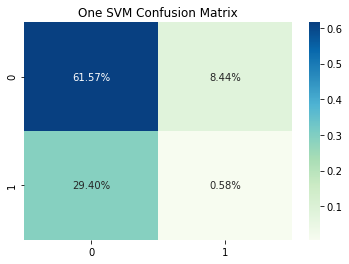

In [30]:
plt.title('One SVM Confusion Matrix')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
confusion = confusion_matrix(labels,OnesvmpredAll2)
new_matrix = np.array([[confusion[1][0],confusion[1][2]],[confusion[2][0],confusion[2][2]]])
matrix_labels = ['True Neg','False Pos','False Neg','True Pos']
sns.heatmap(new_matrix/np.sum(new_matrix), annot=True,cmap='GnBu',fmt='.2%')

D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:   11.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 117 out of 140 | elapsed:    6.6s remaining:    1.2s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    8.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    7.4s finished


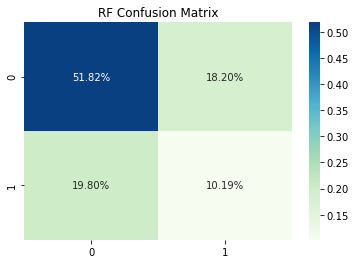

In [31]:
# Random Forest
# Parameter tuning by grid search
RFparameters = {'n_estimators': 10*np.arange(1,21)}

RFgsAll = GridSearchCV(RandomForestClassifier(),
                     RFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
RFgsAll.fit(featuresAll,labels,groups)
RFbestNumTreesAll = RFgsAll.best_params_['n_estimators']

RFgsAcc = GridSearchCV(RandomForestClassifier(),
                     RFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
RFgsAcc.fit(featuresAcc,labels,groups)
RFbestNumTreesAcc = RFgsAcc.best_params_['n_estimators']

RFgsEda = GridSearchCV(RandomForestClassifier(),
                     RFparameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
RFgsEda.fit(featuresEda,labels,groups)
RFbestNumTreesEda = RFgsEda.best_params_['n_estimators']

RFpredAll = np.zeros(np.shape(labels))
RFpredAll2 = np.zeros(np.shape(labels))
RFpredAcc = np.zeros(np.shape(labels))
RFpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    RFAll = RandomForestClassifier(n_estimators=RFbestNumTreesAll)
    RFAll.fit(featuresAll[train,:],labels[train])
    RFpredAll[test] = RFAll.predict_proba(featuresAll[test,:])[:,1]
    RFpredAll2[test] =RFAll.predict(featuresAll[test,:])
    RFAcc = RandomForestClassifier(n_estimators=RFbestNumTreesAcc)
    RFAcc.fit(featuresAcc[train,:],labels[train])
    RFpredAcc[test] = RFAcc.predict_proba(featuresAcc[test,:])[:,1]

    RFEda = RandomForestClassifier(n_estimators=RFbestNumTreesEda)
    RFEda.fit(featuresEda[train,:],labels[train])
    RFpredEda[test] = RFEda.predict_proba(featuresEda[test,:])[:,1]
    
plt.title('RF Confusion Matrix')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
confusion = confusion_matrix(labels,RFpredAll2)
matrix_labels = ['True Neg','False Pos','False Neg','True Pos']
sns.heatmap(confusion/np.sum(confusion), annot=True,cmap='GnBu',fmt='.2%')

D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 560 out of 560 | elapsed:    2.9s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 560 out of 560 | elapsed:    2.1s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=12)]: Done 560 out of 560 | elapsed:    0.9s finished


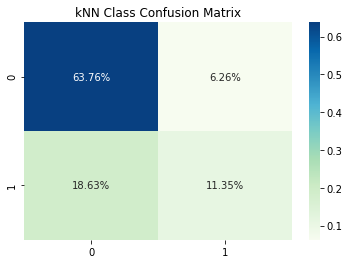

In [32]:
# kNN classify
# Parameter tuning by grid search
parameters = {'n_neighbors': np.arange(1, 81)}

kNNgsAll = GridSearchCV(KNeighborsClassifier(algorithm='auto', metric='euclidean'),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
kNNgsAll.fit(featuresAll,labels,groups)
bestneighbors_All = kNNgsAll.best_params_['n_neighbors']

kNNgsAcc = GridSearchCV(KNeighborsClassifier(algorithm='auto', metric='euclidean'),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
kNNgsAcc.fit(featuresAcc,labels,groups)
bestneighbors_Acc = kNNgsAcc.best_params_['n_neighbors']

kNNgsEda = GridSearchCV(KNeighborsClassifier(algorithm='auto', metric='euclidean'),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
kNNgsEda.fit(featuresEda,labels,groups)
bestneighbors_Eda = kNNgsEda.best_params_['n_neighbors']              

knnCpredAll = np.zeros(np.shape(labels))
knnCpredAll2 = np.zeros(np.shape(labels))
knnCpredAcc = np.zeros(np.shape(labels))
knnCpredEda = np.zeros(np.shape(labels))              
for train, test in cv.split(featuresAll,labels,groups):
    knnCAll = KNeighborsClassifier(n_neighbors=bestneighbors_All, algorithm='auto', metric='euclidean')
    knnCAll.fit(featuresAll[train,:],labels[train])
    knnCpredAll[test] = knnCAll.predict_proba(featuresAll[test,:])[:,1]
    knnCpredAll2[test] = knnCAll.predict(featuresAll[test,:])
    
    knnCAcc = KNeighborsClassifier(n_neighbors=bestneighbors_Acc, algorithm='auto', metric='euclidean')
    knnCAcc.fit(featuresAcc[train,:],labels[train])
    knnCpredAcc[test] = knnCAcc.predict_proba(featuresAcc[test,:])[:,1]

    knnCEda = KNeighborsClassifier(n_neighbors=bestneighbors_Eda, algorithm='auto', metric='euclidean')
    knnCEda.fit(featuresEda[train,:],labels[train])
    knnCpredEda[test] = knnCEda.predict_proba(featuresEda[test,:])[:,1]
    
plt.title('kNN Class Confusion Matrix')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
confusion = confusion_matrix(labels,knnCpredAll2)
matrix_labels = ['True Neg','False Pos','False Neg','True Pos']
sns.heatmap(confusion/np.sum(confusion), annot=True,cmap='GnBu',fmt='.2%')

D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2

Fitting 7 folds for each of 90 candidates, totalling 630 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 630 out of 630 | elapsed:    4.7s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1

Fitting 7 folds for each of 90 candidates, totalling 630 fits


[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 575 tasks      | elapsed:    3.2s
[Parallel(n_jobs=12)]: Done 607 out of 630 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 630 out of 630 | elapsed:    3.5s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.

Fitting 7 folds for each of 90 candidates, totalling 630 fits


[Parallel(n_jobs=12)]: Done 607 out of 630 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 630 out of 630 | elapsed:    1.9s finished


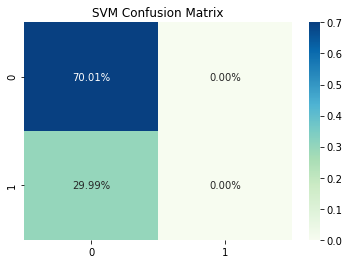

In [33]:
# Svm
# Parameter tuning by grid search
regParamC = 10. ** np.arange(-5, 4)
regParamG = 10. ** np.arange(-9, 1)
parameters = {'gamma': regParamG, 'C': regParamC}
              
svmgsAll = GridSearchCV(svm.SVC(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)              
svmgsAll.fit(featuresAll,labels,groups)


svmbestgamma_All = svmgsAll.best_params_['gamma']
svmbestC_All = svmgsAll.best_params_['C']

svmgsAcc = GridSearchCV(svm.SVC(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
svmgsAcc.fit(featuresAcc,labels,groups)
svmbestgamma_Acc = svmgsAcc.best_params_['gamma']
svmbestC_Acc = svmgsAcc.best_params_['C']

svmgsEda = GridSearchCV(svm.SVC(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
svmgsEda.fit(featuresEda,labels,groups)
svmbestgamma_Eda = svmgsEda.best_params_['gamma']
svmbestC_Eda = svmgsEda.best_params_['C']

svmpredAll = np.zeros(np.shape(labels))
svmpredAll2 = np.zeros(np.shape(labels))
svmpredAcc = np.zeros(np.shape(labels))
svmpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    svmAll = svm.SVC(gamma=svmbestgamma_All, C=svmbestC_All,probability=True)
    svmAll.fit(featuresAll[train,:],labels[train])
    svmpredAll[test] = svmAll.predict_proba(featuresAll[test,:])[:,1]
    svmpredAll2[test] = svmAll.predict(featuresAll[test,:])
    svmAcc = svm.SVC(gamma=svmbestgamma_Acc, C=svmbestC_Acc,probability=True)
    svmAcc.fit(featuresAcc[train,:],labels[train])
    svmpredAcc[test] = svmAcc.predict_proba(featuresAcc[test,:])[:,1]

    svmEda = svm.SVC(gamma=svmbestgamma_Eda, C=svmbestC_Eda,probability=True)
    svmEda.fit(featuresEda[train,:],labels[train])
    svmpredEda[test] = svmEda.predict_proba(featuresEda[test,:])[:,1]
    
plt.title('SVM Confusion Matrix')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
confusion = confusion_matrix(labels,svmpredAll2)

matrix_labels = ['True Neg','False Pos','False Neg','True Pos']
sns.heatmap(confusion/np.sum(confusion), annot=True,cmap='GnBu',fmt='.2%')

D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  47 out of  70 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.4s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.3s finished
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=roc_auc as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\Engineering\PROJECTMARS\envs\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass groups=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  47 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  70 out of  70 | elapsed:    0.2s finished


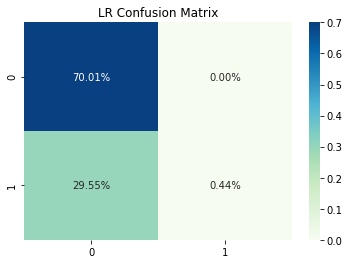

In [34]:
# Logistic
# Parameter tuning by grid search
regParam = 10.0**-np.arange(-5,5)
parameters = {'C': regParam}

gsAll = GridSearchCV(LogisticRegression(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsAll.fit(featuresAll,labels,groups)
bestC_All = gsAll.best_params_['C']

gsAcc = GridSearchCV(LogisticRegression(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsAcc.fit(featuresAcc,labels,groups)
bestC_Acc = gsAcc.best_params_['C']

gsEda = GridSearchCV(LogisticRegression(),
                     parameters,'roc_auc',n_jobs=nJobs,cv=cv,refit=False,
                     verbose=1)
gsEda.fit(featuresEda,labels,groups)
bestC_Eda = gsEda.best_params_['C']

LogisticpredAll = np.zeros(np.shape(labels))
LogisticpredAll2 = np.zeros(np.shape(labels))
LogisticpredAcc = np.zeros(np.shape(labels))
LogisticpredEda = np.zeros(np.shape(labels))
for train, test in cv.split(featuresAll,labels,groups):
    lrAll = LogisticRegression(C=bestC_All)
    lrAll.fit(featuresAll[train,:],labels[train])
    LogisticpredAll[test] = lrAll.predict_proba(featuresAll[test,:])[:,1]
    LogisticpredAll2[test] = lrAll.predict(featuresAll[test,:])
    lrAcc = LogisticRegression(C=bestC_Acc)
    lrAcc.fit(featuresAcc[train,:],labels[train])
    LogisticpredAcc[test] = lrAcc.predict_proba(featuresAcc[test,:])[:,1]

    lrEda = LogisticRegression(C=bestC_Eda)
    lrEda.fit(featuresEda[train,:],labels[train])
    LogisticpredEda[test] = lrEda.predict_proba(featuresEda[test,:])[:,1]
    
plt.title('LR Confusion Matrix')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
confusion = confusion_matrix(labels,LogisticpredAll2)

matrix_labels = ['True Neg','False Pos','False Neg','True Pos']
sns.heatmap(confusion/np.sum(confusion), annot=True,cmap='GnBu',fmt='.2%')